<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/master/nb/Zheng2007_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Zheng2007 in diffhod 
This notebook illustrates how to implenent Zheng2007, and compare the results to halotools

## Preliminary setup


Here we download and install all the requirements

!pip install halotools
!download_initial_halocat.py 
!pip install --upgrade git+https://github.com/DifferentiableUniverseInitiative/DHOD.git

In [2]:
!nvidia-smi

Sat Apr 17 03:14:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   32C    P8     9W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 16%   37C    P8    24W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

ncc =128


In [4]:
%pylab inline
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow_probability import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

Populating the interactive namespace from numpy and matplotlib
batch mode...


/home/ben.horowitz/miniconda3/envs/dhod2/lib/python3.8/site-packages/diffhod-0.1-py3.8.egg/diffhod/components.py:9: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.


## Prepare halo catalog

In [5]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]

halo_table = halo_table[halo_table['halo_x'] < ncc]
halo_table = halo_table[halo_table['halo_y'] < ncc]
halo_table = halo_table[halo_table['halo_z'] < ncc]
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

## Model definition

In [6]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)

In [7]:
zheng07_model.param_dict

{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [8]:
# Here is how we define the same model in diffhod

@tf.function
def hod(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha, max_sat=40, temp=0.01,bs=10):
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temp)
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      logM0=logM0,
                                      logM1=logM1,
                                      alpha=alpha,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat,  'n_sat':n_sat}

In [9]:
# sampling galaxies from the model

gal_cat = hod(tf_halocat,12.02,0.26,11.38,13.31,1.06)

Tensor("Pow:0", shape=(), dtype=float32)
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [10]:
p = gal_cat['n_cen']>0.5
print(p.shape)

(1, 139905)


In [11]:
# Same thing with halotools
zheng07_model.populate_mock(halocat) 

## Testing 2pt function

In [12]:
# Let's define halotools samples
ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
m = zheng07_model.mock.galaxy_table['host_centric_distance'] <0.0001
filt = np.logical_and(np.logical_and(ht_sample[:,0]<ncc,ht_sample[:,1]<ncc),ht_sample[:,2]<ncc)
ht_cens = ht_sample[np.logical_and(m,filt)]
ht_sats = ht_sample[np.logical_and(filt,np.logical_not(m))]

In [13]:
#p = gal_cat['n_cen']>0.5
#print(p.shape)
#print(gal_cat['pos_cen'].shape)
#print(gal_cat['pos_cen'][p[0,:]].shape)

p = gal_cat['n_sat']>0.5
print("new",p.shape)
print(gal_cat['pos_sat'].shape)
print(gal_cat['pos_sat'][p[:,0,:]].shape)

new (40, 1, 139905)
(40, 139905, 3)
(2221, 3)


In [14]:
# Same thing for dhod
p = gal_cat['n_cen']>0.5
tf_cens = gal_cat['pos_cen'][p[0,:]].numpy()
p = gal_cat['n_sat']>0.5
tf_sats = gal_cat['pos_sat'][p[:,0,:]].numpy().reshape((-1,3))
tf_sample = np.concatenate([tf_cens, tf_sats], axis=0)

In [15]:
ht_sample.shape,tf_sample.shape

((73064, 3), (10176, 3))

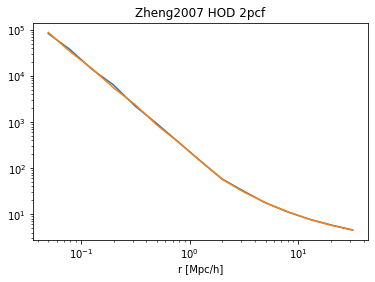

In [16]:
rbins = np.logspace(-1.5, 1.5, 16)
xi_ht = tpcf(ht_sample[filt], rbins, period=halocat.Lbox)
xi_tf = tpcf(tf_sample, rbins, period=halocat.Lbox)

loglog(rbins[1:],xi_ht, label='halotools')
loglog(rbins[1:],xi_tf, label='DHOD')
xlabel('r [Mpc/h]')
title('Zheng2007 HOD 2pcf');

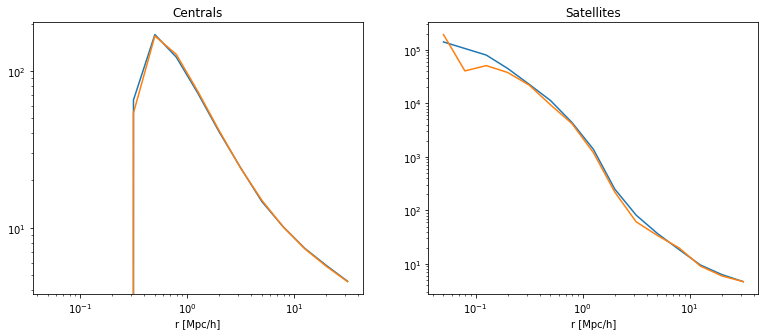

In [17]:
xi_ht_cen = tpcf(ht_cens, rbins, period=halocat.Lbox)
xi_tf_cen = tpcf(tf_cens, rbins, period=halocat.Lbox)
xi_ht_sat = tpcf(ht_sats, rbins, period=halocat.Lbox)
xi_tf_sat = tpcf(tf_sats, rbins, period=halocat.Lbox)

figure(figsize=(13,5))
subplot(121)
loglog(rbins[1:],xi_ht_cen, label='halotools')
loglog(rbins[1:],xi_tf_cen, label='DHOD')
xlabel('r [Mpc/h]')
title('Centrals');

subplot(122)
loglog(rbins[1:],xi_ht_sat, label='halotools')
loglog(rbins[1:],xi_tf_sat, label='DHOD')
xlabel('r [Mpc/h]')
title('Satellites');

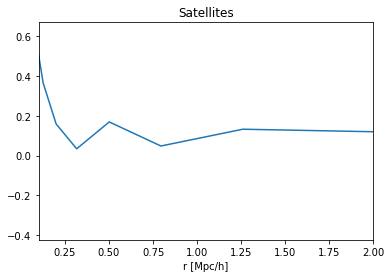

In [18]:
#fractional error for satillites... probably worse part of model?
plot(rbins[1:],(xi_ht_sat-xi_tf_sat)/xi_ht_sat, label='diff')
xlim(0.1,2)
xlabel('r [Mpc/h]')
title('Satellites');

## Field level comparison

In [19]:

@tf.function
def cic_paint(mesh, part, weight=None, name="CiCPaint"):
  """
  Paints particules on a 3D mesh.
  Parameters:
  -----------
  mesh: tensor (batch_size, nc, nc, nc)
    Input 3D mesh tensor
  part: tensor (batch_size, npart, 3)
    List of 3D particle coordinates, assumed to be in mesh units if
    boxsize is None
  weight: tensor (batch_size, npart)
    List of weights  for each particle
  """
  with tf.name_scope(name):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")
    if weight is not None:
      weight = tf.convert_to_tensor(weight, name="weight")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = nz

    # Flatten part if it's not already done
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(tf.constant([[[0, 0, 0], [1., 0, 0],[0., 1, 0],
                                              [0., 0, 1],[1., 1, 0],[1., 0, 1],
                                              [0., 1, 1],[1., 1, 1]]]), 0)

    neighboor_coords = floor + connection
    kernel = 1. - tf.abs(part - neighboor_coords)
    # Replacing the reduce_prod op by manual multiplication
    # TODO: figure out why reduce_prod was crashing the Hessian computation
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    if weight is not None: kernel = tf.multiply(tf.expand_dims(weight, axis=-1) , kernel)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords , nc)

    # Adding batch dimension to the neighboor coordinates
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
    b = tf.tile(batch_idx, [1] + list(neighboor_coords.get_shape()[1:-1]) + [1])
    neighboor_coords = tf.concat([b, neighboor_coords], axis=-1)

    update = tf.scatter_nd(tf.reshape(neighboor_coords, (-1, 8,4)),tf.reshape(kernel, (-1, 8)),[batch_size, nx, ny, nz])
    mesh = mesh + update
    return mesh

# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha, max_sat=40, temp=0.01,bs=10):
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temp)
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      logM0=logM0,
                                      logM1=logM1,
                                      alpha=alpha,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat,  'n_sat':n_sat}

# Here is how we define the same model in diffhod
# @tf.function
# def hod(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha, max_sat=40, temp=0.1,bs=10):
#   ### Occupation model ###
#   n_cen = Zheng07Cens(halo_cat['halo_mvir'],
#                       sigma_logM=sigma_logM,
#                       logMmin=logMmin,
#                       temperature=temp)
#   n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
#                                       n_cen,
#                                       logM0=logM0,
#                                       logM1=logM1,
#                                       alpha=alpha,
#                                       sample_shape=(max_sat,),
#                                       temperature=temp)
  
#   ### Phase Space model ###
#   # Centrals are just located at center of halo
#   pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
#                                         halo_cat['halo_y'],
#                                         halo_cat['halo_z']], axis=-1))

#   # Satellites follow an NFW profile centered on halos
#   pos_sat = NFWProfile(pos=pos_cen,
#                         concentration=halo_cat['halo_nfw_conc'],
#                         Rvir=halo_cat['halo_rvir'],
#                         sample_shape=(max_sat,))
  
#   return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat,  'n_sat':n_sat}


#batch compatable painter
@tf.function
def paint_galaxies(gal_cat, nc=128):
    # Take centrals and rescale them to the boxsize
    
    bs = gal_cat['n_sat'].shape[1]
    
    sample1 = gal_cat['pos_cen'] / ncc * nc
    weights1 = gal_cat['n_cen']
    # Take sats and rescale them to the boxize
  
    sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3]) / ncc * nc
    weights2 = tf.reshape(gal_cat['n_sat'],[bs,-1])
    
    sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])
    print(sample1_r.shape,weights1.shape)
    rho1 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample1_r, weights1)
    sample2_r = tf.tile(tf.expand_dims(sample2,0),[bs,1,1])
    print(sample2_r.shape,weights2.shape)

    rho2 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample2_r, weights2)
    rho = rho1+rho2
    return rho

# sampling galaxies from the model, with given params
@tf.function
def sample(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha):
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha))


In [20]:
p = gal_cat['n_cen']>0.5
tf_cens = gal_cat['pos_cen'][p[0,:]]

In [21]:
bs = gal_cat['n_cen'].shape

In [22]:
gal_cat['pos_sat'].shape, gal_cat['pos_cen'].shape

(TensorShape([40, 139905, 3]), TensorShape([139905, 3]))

In [23]:
bs = 128

sample1 = gal_cat['pos_cen']/ncc*bs
sample1_r = tf.tile(tf.expand_dims(sample1,0),[1,1,1])

sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3])/ncc*bs
sample2_r = tf.tile(tf.expand_dims(sample2,0),[1,1,1])

In [24]:
sample1_r.shape

TensorShape([1, 139905, 3])

In [25]:
painted_central_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample1_r,weight=gal_cat['n_cen'])
painted_sat_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample2_r,weight=tf.reshape(gal_cat['n_sat'], [-1,]))

In [26]:
painted_central_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_cens.reshape(1,-1,3)/ncc*bs)
painted_sat_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sats.reshape(1,-1,3)/ncc*bs)

In [27]:
np.sum(painted_central_hod ),np.sum(painted_central_tf)

(7872.999, 7957.5464)

In [28]:
np.sum(painted_sat_hod )/np.sum(painted_sat_tf)

0.957686

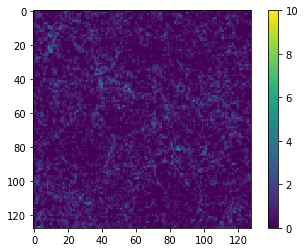

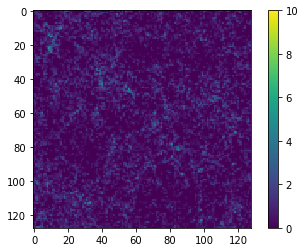

In [29]:
imshow(painted_central_hod[0].numpy().sum(axis=1),vmax=10)
colorbar()
show()
imshow(painted_central_tf[0].numpy().sum(axis=1),vmax=10)
colorbar()


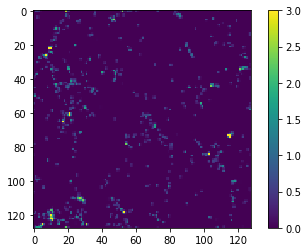

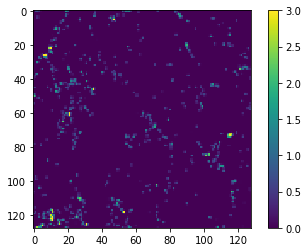

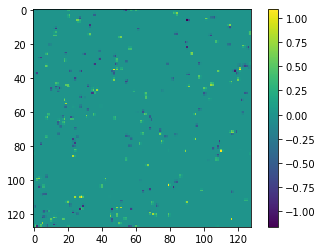

In [30]:

all_hod = painted_central_hod[0,:,10:20,:].numpy().sum(axis=1) + painted_sat_hod[0,:,10:20,:].numpy().sum(axis=1)
all_tf = painted_central_tf[0,:,10:20,:].numpy().sum(axis=1) + painted_sat_hod[0,:,10:20,:].numpy().sum(axis=1)

imshow(painted_central_hod[0,:,10:20,:].numpy().sum(axis=1) + painted_sat_hod[0,:,10:20,:].numpy().sum(axis=1) ,vmax=3)
colorbar()
show()
imshow(painted_central_tf[0,:,10:20,:].numpy().sum(axis=1) + painted_sat_tf[0,:,10:20,:].numpy().sum(axis=1) ,vmax=3)
colorbar()
show()
imshow(all_hod-all_tf)
colorbar()
show()




In [31]:
np.save("central_hod",painted_central_hod)
np.save("sat_hod",painted_sat_hod)
np.save("central_tf",painted_central_tf)
np.save("sat_tf",painted_sat_tf)

In [32]:
np.sum(painted_sat_tf),np.sum(painted_sat_hod)

(2218.8909, 2125.0007)

## Validating Power Spectrum Code

In [33]:

class Power_Spectrum():

    def __init__(self,shape,boxsize,kmin,dk):
        self.shape = shape
        self.boxsize = boxsize
        self.kmin = kmin
        self.dk = dk
        
        self._initialize_pk()
        
    def _initialize_pk(self):
        """
           Helper function to initialize various (fixed) values for powerspectra... not differentiable!
        """
        I = np.eye(len(self.shape), dtype='int') * -2 + 1

        W = np.empty(self.shape, dtype='f4')
        W[...] = 2.0
        W[..., 0] = 1.0
        W[..., -1] = 1.0

        kmax = np.pi * np.min(self.shape)/np.max(self.boxsize) + self.dk/2
        self.kedges = np.arange(self.kmin, kmax, self.dk)

        self.k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(self.shape, self.boxsize, I, self.shape)]
        kmag = sum(ki ** 2 for ki in self.k) ** 0.5

        xsum = np.zeros(len(self.kedges) + 1)
        Nsum = np.zeros(len(self.kedges) + 1)

        dig = np.digitize(kmag.flat, self.kedges)

        xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
        Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
        self.dig = dig
        self.Nsum = Nsum
        self.W = W
        self.xsum = xsum
      #  return dig, Nsum, xsum, W, k, kedges

    @tf.function
    def pk_tf(self,field):  
        """
        Calculate the powerspectra given real space field

        Args:

            field: real valued field 
            kmin: minimum k-value for binned powerspectra
            dk: differential in each kbin
            shape: shape of field to calculate field (can be strangely shaped?)
            boxsize: length of each boxlength (can be strangly shaped?)

        Returns:

            kbins: the central value of the bins for plotting
            power: real valued array of power in each bin

        """

        batchsize = field.shape[0] #batch size
        nc = field.shape[1]
        #print(np.sum(bs))
        #dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)

        #convert field to complex for fft
        field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

        #fast fourier transform
        fft_image = tf.map_fn(tf.signal.fft3d, field_complex)#, dtype=None, parallel_iterations=None, back_prop=True,
        #swap_memory=False, infer_shape=True, name=None
        #)


        #absolute value of fast fourier transform
        pk = tf.math.real(fft_image*tf.math.conj(fft_image))
        #calculating powerspectra
        Psum = tf.zeros(tf.size(self.kedges) + 1, dtype=tf.complex64)
        real = tf.reshape(tf.math.real(pk),[batchsize,-1,])
        imag = tf.reshape(tf.math.imag(pk),[batchsize,-1,])


        #def bincount func
        @tf.function
        def bincount(x):
            return tf.math.bincount(self.dig, weights=(tf.reshape(self.W,[-1])  * x), minlength=tf.size(self.xsum))
        #Psum1 = tf.dtypes.cast(tf.vectorized_map(bincount, imag),dtype=tf.complex64)*1j
        #Psum2 = tf.dtypes.cast(tf.vectorized_map(bincount, real),dtype=tf.complex64)
        Psum1 = tf.dtypes.cast(tf.map_fn(
         bincount, imag, dtype=None, parallel_iterations=None, back_prop=True,
         swap_memory=False, infer_shape=True, name=None
         ),dtype=tf.complex64)*1j

        Psum2 = tf.dtypes.cast(tf.map_fn(
         bincount, real, dtype=None, parallel_iterations=None, back_prop=True,
         swap_memory=False, infer_shape=True, name=None
         ),dtype=tf.complex64)


        power = ((Psum + Psum1+Psum2)/ self.Nsum)[:,1:-1]* tf.cast(self.boxsize[0]**3,dtype=tf.complex64)

        #normalization for powerspectra
        norm = tf.dtypes.cast(nc**3,dtype=tf.float32)**2

        #find central values of each bin
        kbins = self.kedges[:-1]+ (self.kedges[1:] - self.kedges[:-1])/2

        return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm
    

## Should wrap this into a class...

def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0

    kmax = np.pi * np.min(shape)/np.max(boxsize) + dk/2
    kedges = np.arange(kmin, kmax, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape, boxsize, I, shape)]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.Variable(dig,dtype=tf.int32)
    Nsum = tf.Variable(Nsum,dtype=tf.complex64)
    return dig, Nsum, xsum, W, k, kedges


dig, Nsum, xsum, W,  _, kedges = _initialize_pk(np.array([128,128,128]),np.array([128,128,128]),kmin=0.045,dk=.049)

@tf.function
def pk_tf(field,dig=dig, Nsum=Nsum, xsum=xsum, W=W,  kedges=kedges,kmin=5,dk=0.8,boxsize=np.array([128,128,128])):  
    print("traced!")
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
     
    batchsize = field.shape[0] #batch size
    nc = field.shape[1]
    #print(np.sum(bs))
    #dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)

    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.map_fn(tf.signal.fft3d, field_complex)#, dtype=None, parallel_iterations=None, back_prop=True,
    #swap_memory=False, infer_shape=True, name=None
    #)


    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[batchsize,-1,])
    imag = tf.reshape(tf.math.imag(pk),[batchsize,-1,])


    #def bincount func
    @tf.function
    def bincount(x):
        return tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * x), minlength=tf.size(xsum))
    #Psum1 = tf.dtypes.cast(tf.vectorized_map(bincount, imag),dtype=tf.complex64)*1j
    #Psum2 = tf.dtypes.cast(tf.vectorized_map(bincount, real),dtype=tf.complex64)
    Psum1 = tf.dtypes.cast(tf.map_fn(
     bincount, imag, dtype=None, parallel_iterations=None, back_prop=True,
     swap_memory=False, infer_shape=True, name=None
     ),dtype=tf.complex64)*1j
    
    Psum2 = tf.dtypes.cast(tf.map_fn(
     bincount, real, dtype=None, parallel_iterations=None, back_prop=True,
     swap_memory=False, infer_shape=True, name=None
     ),dtype=tf.complex64)
    

    power = ((Psum + Psum1+Psum2)/ Nsum)[:,1:-1]* tf.cast(boxsize[0]**3,dtype=complex64)

    #normalization for powerspectra
    norm = tf.dtypes.cast(nc**3,dtype=tf.float32)**2

    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2

    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

In [34]:
import nbodykit.lab as NBlab


In [35]:
#subdivided catalog

# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < ncc]
halo_table = halo_table[halo_table['halo_y'] < ncc]
halo_table = halo_table[halo_table['halo_z'] < ncc]
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

In [36]:
ncc

128

In [37]:
from nbodykit.lab import *
import nbodykit

def box_pk_nbodykit(box):
    mesh = nbodykit.source.mesh.array.ArrayMesh(box, ncc)
    kf = 2.*np.pi/ncc # fundamental mode
    r = NBlab.FFTPower(mesh, mode='1d', dk=kf, kmin=kf)
    Pk = r.power
    return Pk['k'], Pk['power'].real - Pk.attrs['shotnoise']

def model_pk(bs=128):
    halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 
    zheng07_model.populate_mock(halocat) 
    ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
    filt= np.logical_and(np.logical_and(ht_sample[:,0]<ncc,ht_sample[:,1]<ncc),ht_sample[:,2]<ncc)
    field = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sample[filt].reshape(1,-1,3))

   # data = numpy.empty(ht_sample.shape[0], dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])

   # data['Position'] = ht_sample/250*bs
    #data['Mass'] = np.ones(ht_sample.shape[0])
    #f = ArrayCatalog(data)
    #mesh = f.to_mesh(BoxSize=128,Nmesh=128,window='cic')
    #one_plus_delta = mesh.paint(mode='real')

    return box_pk_nbodykit(field[0])#,field[0]

In [38]:
2.*np.pi/128

0.04908738521234052

In [39]:
k_a2, Pk_a2 = model_pk()

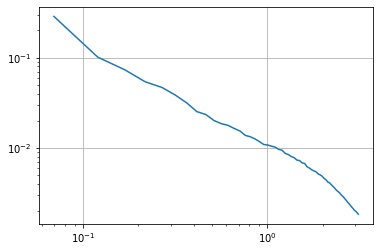

In [40]:
loglog(k_a2, Pk_a2)
grid()

## Samples for covariance estimation

In [41]:
pk_out = []
for i in range(0,100):
    print("run",i,"/100")
    k_a, Pk_a = model_pk()
    pk_out.append(Pk_a)

run 0 /100


In [42]:
#or load/save an existing set of pk
#np.save("pk_out",np.array(pk_out))
#pk_out = np.load("pk_out.npy")

[]

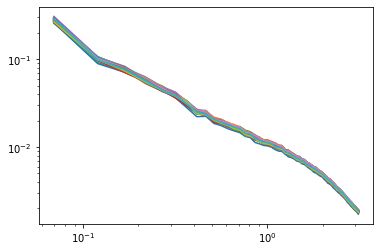

In [43]:

pk_obs = np.mean(pk_out,axis=0)

for i in pk_out:
    plt.plot(k_a, i)

loglog()


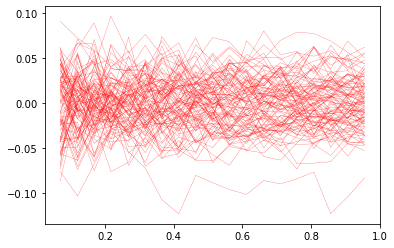

In [44]:
#we only care about k<1.0
klim = (k_a < 1.)

k_arr = k_a[klim]

for i in pk_out[:]:
    plt.plot(k_a[klim], (i[klim]-pk_obs[klim])/pk_obs[klim],"r",linewidth=0.2)


## Double check DHOD implementation matches hod implementation...

In [45]:
k_nbody, Pk_nbody = box_pk_nbodykit(painted_central_hod[0,:,:,:]+painted_sat_hod[0,:,:,:])
k_tf, Pk_tf = box_pk_nbodykit(painted_central_tf[0,:,:,:]+painted_sat_tf[0,:,:,:])

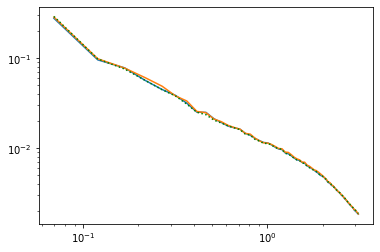

In [46]:

plt.loglog(k_nbody, Pk_nbody)

plt.loglog(k_tf, Pk_tf)

plt.plot(k_a, i, 'g:')




## Double check that TF Power Spectra matches NBODYKIT Power Spectra

In [47]:
import routines as rt

ps = rt.Power_Spectrum([128,128,128],[128,128,128],
         kmin=tf.constant(0.045),dk=tf.constant(.049))
k2, pkr2 = ps.pk_tf(np.array(painted_central_hod[0,:,:,:]+painted_sat_hod[0,:,:,:]).reshape(1,128,128,128))
       #  shape = np.array([128,128,128]), 
       #  boxsize = np.array([128,128,128]), 
       #  kmin=0.045,dk=.049)

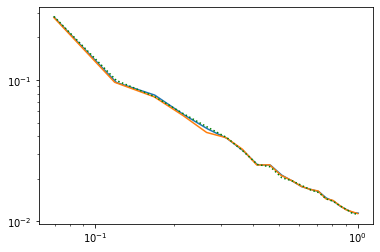

In [48]:
plt.loglog(k_nbody[:20], Pk_nbody[:20])
plt.loglog(k2[:20], pkr2[0][:20])
plt.plot(k_a[:20], pk_obs[:20], 'g:')


In [49]:
klim_2 = k2<1.0

## Calculate Covariance

In [50]:
pk_fid = np.array( pk_out)[:,klim]

cov_pk = np.cov(pk_fid.T)
cinv_pk = np.linalg.inv(cov_pk)
f_hartlap = (float(100) - float(pk_fid.shape[1]) -2.)/(float(100) - 1.)
print(f_hartlap)

0.797979797979798


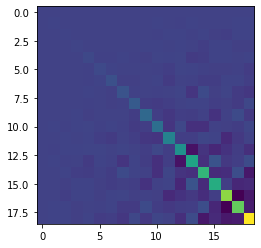

In [51]:
imshow(cinv_pk)

In [52]:
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 
#.param_dict
zheng07_model.populate_mock(halocat) 

In [53]:
zheng07_model.param_dict

{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [54]:
bs

128

In [55]:
def model_pk_iterate(theta):
    halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 
    zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)
    zheng07_model.param_dict['logMmin'] =theta[0] 
    zheng07_model.param_dict['sigma_logM'] =theta[1] 
    zheng07_model.param_dict['logM0'] =theta[2] 
    zheng07_model.param_dict['logM1'] =theta[3] 
    zheng07_model.param_dict['alpha'] =theta[4] 

    zheng07_model.populate_mock(halocat) 
    
    
    ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
    filt= np.logical_and(np.logical_and(ht_sample[:,0]<ncc,ht_sample[:,1]<ncc),ht_sample[:,2]<ncc)

    field = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sample[filt].reshape(1,-1,3)/ncc*bs)
    
   # data = numpy.empty(ht_sample.shape[0], dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])

   # data['Position'] = ht_sample/250*bs
   # data['Mass'] = np.ones(ht_sample.shape[0])
    #f = ArrayCatalog(data)
   # mesh = f.to_mesh(BoxSize=128,Nmesh=128,window='cic')
    #one_plus_delta = mesh.paint(mode='real')

    return box_pk_nbodykit(field[0])

def model_pk_iterate_nbk(theta):
    halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 
    zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)
    zheng07_model.param_dict['logMmin'] =theta[0] 
    zheng07_model.param_dict['sigma_logM'] =theta[1] 
    zheng07_model.param_dict['logM0'] =theta[2] 
    zheng07_model.param_dict['logM1'] =theta[3] 
    zheng07_model.param_dict['alpha'] =theta[4] 

    zheng07_model.populate_mock(halocat) 
    
    
    ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
    filt= np.logical_and(np.logical_and(ht_sample[:,0]<ncc,ht_sample[:,1]<ncc),ht_sample[:,2]<ncc)

    field = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sample[filt].reshape(1,-1,3)/ncc*bs)
    return box_pk_nbodykit(field[0])

In [58]:
theta = [12.02,0.26,11.38,13.31,1.06]
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 
zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)
zheng07_model.param_dict['logMmin'] =theta[0] 
zheng07_model.param_dict['sigma_logM'] =theta[1] 
zheng07_model.param_dict['logM0'] =theta[2] 
zheng07_model.param_dict['logM1'] =theta[3] 
zheng07_model.param_dict['alpha'] =theta[4]     

In [60]:
%timeit    zheng07_model.populate_mock(halocat) 


988 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
k_b,pk_b=model_pk_iterate([12.02,0.26,11.38,13.31,1.06])
k_c,pk_c=model_pk_iterate([12.02,0.96,11.38,13.31,1.06])

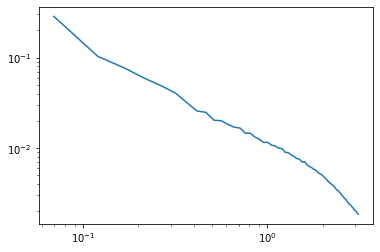

In [57]:
loglog(k_b,pk_b)

plt.loglog(k_b,pk_b)
plt.loglog(k_c,pk_c)
plt.loglog(k_a[:19],pk_obs,"g:")

In [59]:
pk_obs = np.mean(pk_fid, axis=0) # our "observed P(k)"

In [60]:
pk_obs

array([0.28154606, 0.09932119, 0.07624751, 0.05755408, 0.04623149,
       0.0391251 , 0.03139511, 0.02527596, 0.02432823, 0.02036522,
       0.0193781 , 0.01795803, 0.01667617, 0.01599   , 0.01442085,
       0.01386326, 0.01285997, 0.01214123, 0.01136832])

In [62]:
import emcee


In [63]:
def lnProb(theta): 
    '''log probability
    '''
    _, _pk_model = model_pk_iterate(theta)
    pk_model = _pk_model[klim_2]
    
    dpk = pk_model - pk_obs 
    chi2 = np.dot(dpk, np.dot(cinv_pk, dpk))
    return -0.5*chi2

In [64]:
theta_fid = np.array([12.02, 0.26, 11.38, 13.31, 1.06]) # value from https://github.com/DifferentiableUniverseInitiative/DHOD/blob/batch_hmc/nb/batch_hod-hmc-overview.ipynb


theta_off = np.array([12.02, 0.46, 11.58, 13.31, 1.06]) # value from https://github.com/DifferentiableUniverseInitiative/DHOD/blob/batch_hmc/nb/batch_hod-hmc-overview.ipynb


In [65]:
lnProb(theta_fid),lnProb(theta_off),

(-15.112010952669733, -64.17020255926353)

In [66]:
# 32 walkers
pos = theta_off + 1e-4 * np.random.randn(16, theta_fid.shape[0])
nwalkers, ndim = pos.shape

In [67]:

filename = "test3.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [ ]:
import time
start_time = time.time()
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnProb, backend=backend)
sampler.run_mcmc(pos, 10000);
finish_time = time.time()

In [ ]:
#total time
(start_time-finish_time)/60/60

In [ ]:
import corner

corner.corner(sampler.flatchain)

In [ ]:
#np.save("MCMC_Output_041221",sampler.chain)

In [ ]:
value1 = [12.02, 0.26, 11.38,13.31, 1.06]
#range=[(11.5,12.4),(0.00,0.60),(13.1,14.1),(0.950,1.3)]
levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)
figure = corner.corner(sampler.chain[:,1250:,:].reshape(-1,5),labels = [r"$\log M_{min}$", r"$\sigma_{\log M}$", r"$M_0$",r"$\log M_1$", r"$\alpha$"],label_kwargs={"fontsize":18} ,
                       quantiles=[0.16, 0.5, 0.84],levels=levels,show_titles=True,
                       smooth=1.50,range=[[11.8,12.2],[0.0,1.0],[10,12.8],[12.9,13.6],[0.60,1.6]])
ndim = 5
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
        ax.plot(value1[xi], value1[yi], "sg")
plt.savefig("MCMC_Output.pdf")

